# Time Series Feature Store

In [ ]:
# Imports.
import numpy as np
from matplotlib import pyplot as plt
import sys
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, fashion_mnist

TensorFlow 1.x selected.


In [ ]:
pip install pwlf

  Created wheel for pwlf: filename=pwlf-2.0.4-cp37-none-any.whl size=16143 sha256=215f116b120033c7d996e46eb3caf5410805016bea03237728eab5729618d072
  Stored in directory: /root/.cache/pip/wheels/aa/b4/ef/2cb67a24a71a0d9dd93a5ba02f46106e9fa34dd2e3d9d8b4a0
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=f72709e742eec344a51db22a9c1439d499f34910766b48df75b1c34319943154
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pwlf pyDOE


In [ ]:
import pwlf

In [ ]:
pip install iteration_utilities

     |████████████████████████████████| 286kB 6.7MB/s 


In [ ]:
from iteration_utilities import deepflatten

## Univariate

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


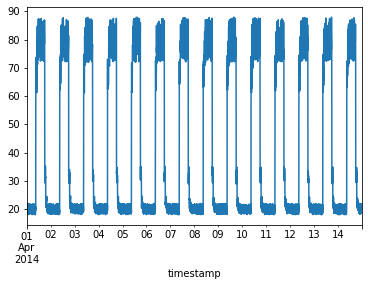

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

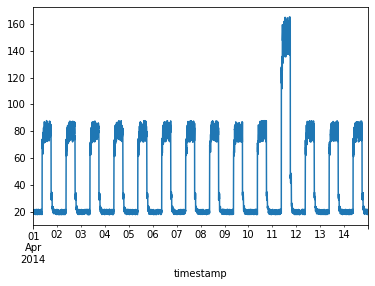

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [ ]:
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [ ]:
TIME_STEPS = 256

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)

train_dataset = create_sequences(df_training_value.values)
print("Training input shape: ", train_dataset.shape)
x_train = train_dataset

Training input shape:  (3776, 256, 1)


### VQ-VAE

In [ ]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))

        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(params=w, ids=encoding_indices)

In [ ]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance

        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss

        return recon_loss + loss #* beta
    return vq_vae_loss

In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           1024      
____________________________________________________________

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3398 samples, validate on 378 samples
Epoch 1/50
3398/3398 [==============================] - 3s 970us/sample - loss: 0.3035 - val_loss: 0.0861
Epoch 2/50
3398/3398 [==============================] - 0s 97us/sample - loss: 0.0913 - val_loss: 0.0611
Epoch 3/50
3398/3398 [==============================] - 0s 95us/sample - loss: 0.0670 - val_loss: 0.0395
Epoch 4/50
3398/3398 [==============================] - 0s 91us/sample - loss: 0.0527 - val_loss: 0.0329
Epoch 5/50
3398/3398 [==============================] - 0s 96us/sample - loss: 0.0445 - val_loss: 0.0260
Epoch 6/50
3398/3398 [==============================] - 0s 91us/sample - loss: 0.0404 - val_loss: 0.0234
Epoch 7/50
3398/3398 [==============================] - 0s 92us/sample - loss: 0.0381 - val_loss: 0.0225
Epoch 8/50
3398/3398 [==============================] - 0s 93us/sample - loss: 0.0359 - val_loss: 0.0215
Epoch 9/50
3398/33

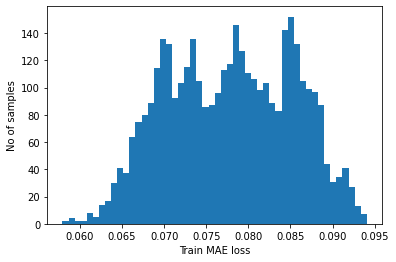

Reconstruction error threshold:  0.0940684867542575


In [ ]:
# Get train MAE loss.
x_train_pred = vqvae.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
y_original = np.array(list(deepflatten(x_train, depth=2)))
y_predicted = np.array(list(deepflatten(x_train_pred, depth=2)))
error_vq_vae = np.mean(np.subtract(y_original,y_predicted)**2)
print(error_vq_vae)

0.015588147491630117


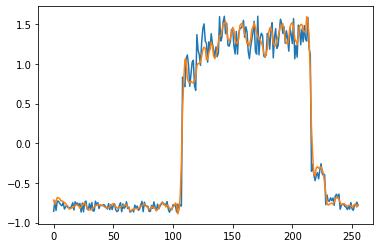

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
len(intermediate_output)

3776

In [ ]:
intermediate_output

In [ ]:
def dictionary_encoding(intermediate_output):

  global i
  global j
  i = -1
  j = -1

  encoded_vectors = {}
  for emb_1 in intermediate_output:
    i +=1
    j = -1
    for emb_2 in emb_1:
      j +=1
      emb_2 = tuple(emb_2)
      #print(emb_2)
      if emb_2 in encoded_vectors:

        previous = encoded_vectors[emb_2]
        previous.append((i,j))
        encoded_vectors[emb_2] = previous
      else:
        encoded_vectors[emb_2] = [(i,j)]
  return encoded_vectors

In [ ]:
def dictionary_decoding(embedded_dictionary):

  for key, value

In [ ]:
len(list(encoded_vectors.keys()))

43

In [ ]:
embedded_size = sys.getsizeof(encoded_vectors)
original_size = sys.getsizeof(df_training_value)
print("Compression: ", embedded_size/original_size)

Compression:  0.035448686167575606


###Piecewise linear fit

In [ ]:
x = np.array(range(0,len(df_training_value.value)))[0:400]
y = np.array(df_training_value.iloc[:,0].values)[:400]

In [ ]:
my_pwlf = pwlf.PiecewiseLinFit(x, y)
breaks = my_pwlf.fit(5)

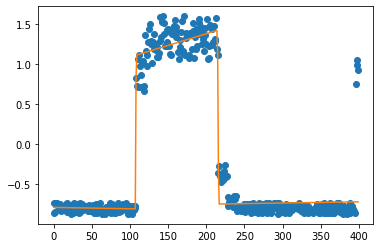

In [ ]:
x_hat = x
y_hat = my_pwlf.predict(x_hat)


plt.figure()
plt.plot(x, y, 'o')
plt.plot(x_hat, y_hat, '-')
plt.show()

In [ ]:
plf = sys.getsizeof(my_pwlf)
original_size = sys.getsizeof(df_training_value)
print("Compression plf: ", plf/original_size)

Compression plf:  0.0009915716410510659


In [ ]:
error_plf = np.mean((y-y_hat)**2)
print(error_plf)

0.043688836417381326


###Fourier Transform

In [ ]:
df = np.fft.fft(df_training_value)

In [ ]:
df[0]

array([-0.85882857+0.j])

In [ ]:
df_size = sys.getsizeof(df)
print(df_size)

64624


In [ ]:
original = np.fft.ifft(df).real
print(len(original))
original_df = sys.getsizeof(original)
print(original_df)

4032
112


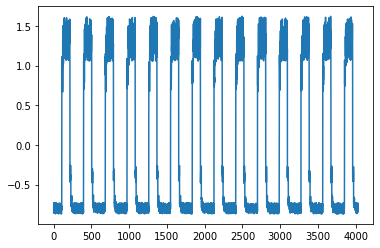

In [ ]:
plt.plot(original)

In [ ]:
error_dft = np.mean((np.array(df_training_value.iloc[0])-original)**2)
print(error_dft)

1.7373384978809772


### Plots

Text(0, 0.5, 'Reconstruction Error')

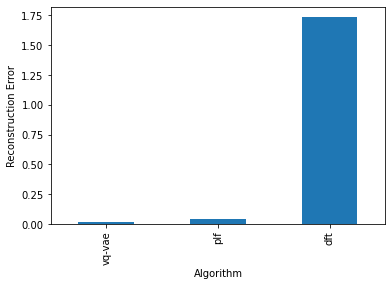

In [ ]:
#Reconstruction error

error = [0.0155, 0.044, 1.737]
algorithm = ['vq-vae','plf' , 'dft']
df_error = pd.DataFrame(error, index = algorithm)
df_error.plot(kind = 'bar', legend = False)
plt.xlabel("Algorithm")
plt.ylabel("Reconstruction Error")

Text(0, 0.5, 'Training time (s)')

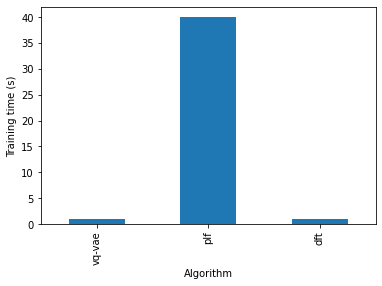

In [ ]:
#Encoding time
#training time vq_vae 11s

error = [1, 40, 1]
algorithm = ['vq-vae','plf' , 'dft']
df_error = pd.DataFrame(error, index = algorithm)
df_error.plot(kind = 'bar', legend = False)
plt.xlabel("Algorithm")
plt.ylabel("Training time (s)")

Text(0, 0.5, 'Compression ratio')

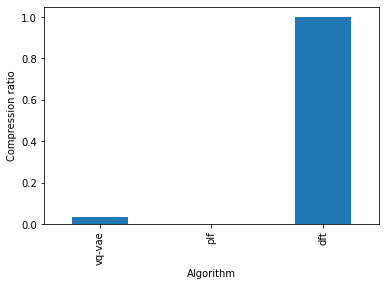

In [ ]:
#Compression rate

compression = [0.035, 0.001, 1]
algorithm = ['vq-vae','plf' , 'dft']
df_compression = pd.DataFrame(compression, index = algorithm)
df_compression.plot(kind = 'bar', legend = False)
plt.xlabel("Algorithm")
plt.ylabel("Compression ratio")

##Multivariate

In [ ]:
data_path = 'Metro_Interstate_Traffic_Volume.csv'
traffic = pd.read_csv(data_path)

In [ ]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
traffic = traffic.rename(columns={'date_time': 'ds', 'traffic_volume': 'y'})
y = traffic['y']
ds = traffic['ds']
X = traffic.drop(['holiday','ds', 'weather_main','snow_1h', 'weather_description'], axis = 1)
X

,temp,rain_1h,clouds_all,y
0,288.28,0.0,40,5545
1,289.36,0.0,75,4516
2,289.58,0.0,90,4767
3,290.13,0.0,90,5026
4,291.14,0.0,75,4918
...,...,...,...,...
48199,283.45,0.0,75,3543
48200,282.76,0.0,90,2781
48201,282.73,0.0,90,2159
48202,282.09,0.0,90,1450


In [ ]:
X.describe()

,temp,rain_1h,clouds_all,y
count,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,49.362231,3259.818355
std,13.338232,44.789133,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,100.000000,7280.000000


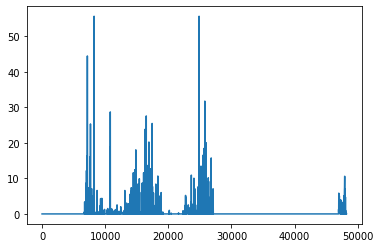

In [ ]:
X_new = X['rain_1h'].replace(9831.30,55.63)
X_new.plot()

In [ ]:
X['rain_1h'] = X['rain_1h'].replace(9831.30,55.63)

In [ ]:
TIME_STEPS = 256

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values.iloc[i : (i + time_steps),:])
    
    return np.stack(output)

train_dataset_m = create_sequences(X)
print("Training input shape: ", train_dataset_m.shape)
x_train_m = train_dataset_m

Training input shape:  (47948, 256, 4)


#### 1D Conv

In [ ]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))

        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(params=w, ids=encoding_indices)

In [ ]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance

        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss

        return recon_loss + loss #* beta
    return vq_vae_loss

##### Base

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 128 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           4096      
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 64, 16)            3600

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 4s 285us/sample - loss: 36052.2398 - val_loss: 1028.0509
Epoch 2/150
13788/13788 [==============================] - 3s 192us/sample - loss: 587.5160 - val_loss: 289.9424
Epoch 3/150
13788/13788 [==============================] - 3s 193us/sample - loss: 162.4159 - val_loss: 132.9850
Epoch 4/150
13788/13788 [==============================] - 3s 197us/sample - loss: 67.1091 - val_loss: 77.5131
Epoch 5/150
13788/13788 [==============================] - 3s 194us/sample - loss: 36.6305 - val_loss: 51.9785
Epoch 6/150
13788/13788 [==============================] - 3s 194us/sample - loss: 24.0602 - val_loss: 37.3254
Epoch 7/150
13788/13788 [==============================] - 3s 193us/sample - loss: 17.3472 - val_loss: 27.3804
Epoch 8/150
13788/13788 [==============================] - 3s 193us/sample - loss: 12.8817 - val_loss: 20.4133
Epoch 9/150
13788/13788 [=============================

In [ ]:
#3m36s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(15321, 256, 4)

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

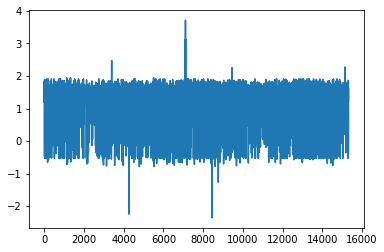

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.225614
1    6.471033
2    0.183304
3    0.143711
dtype: float64

##### 1st

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           2048      
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 64, 16)            3600

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 4s 314us/sample - loss: 25858.9986 - val_loss: 586.9316
Epoch 2/150
13788/13788 [==============================] - 3s 190us/sample - loss: 440.7206 - val_loss: 152.5172
Epoch 3/150
13788/13788 [==============================] - 3s 192us/sample - loss: 147.9121 - val_loss: 70.9511
Epoch 4/150
13788/13788 [==============================] - 3s 193us/sample - loss: 76.0114 - val_loss: 42.5402
Epoch 5/150
13788/13788 [==============================] - 3s 193us/sample - loss: 48.5767 - val_loss: 28.7894
Epoch 6/150
13788/13788 [==============================] - 3s 194us/sample - loss: 35.2750 - val_loss: 22.3349
Epoch 7/150
13788/13788 [==============================] - 3s 193us/sample - loss: 27.7393 - val_loss: 17.7652
Epoch 8/150
13788/13788 [==============================] - 3s 193us/sample - loss: 22.0579 - val_loss: 14.3180
Epoch 9/150
13788/13788 [==============================]

In [ ]:
#2min35s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(15321, 256, 4)

In [ ]:
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])

In [ ]:
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)

In [ ]:
original_mean = df_original.mean(axis = 0)
original_mean

0     276.948124
1       0.158941
2      54.046081
3    3249.415965
dtype: float64

In [ ]:
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))
difference_mean

0    145.412949
1      1.323552
2     21.742738
3    684.730466
dtype: float64

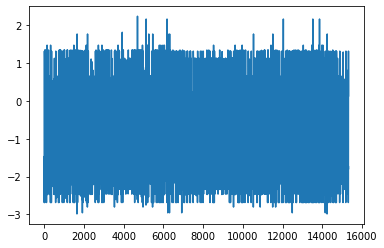

In [ ]:
df_pred.iloc[:,1].plot()

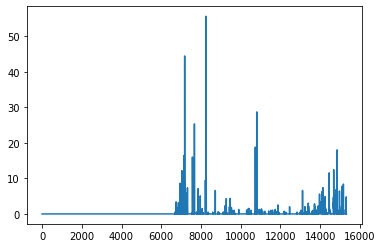

In [ ]:
df_original.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.525055
1    8.327303
2    0.402300
3    0.210724
dtype: float64

##### 2nd

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           1024      
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 64, 16)            3600

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 4s 322us/sample - loss: 47299.6553 - val_loss: 954.9926
Epoch 2/150
13788/13788 [==============================] - 3s 189us/sample - loss: 530.0677 - val_loss: 306.6636
Epoch 3/150
13788/13788 [==============================] - 3s 190us/sample - loss: 179.1089 - val_loss: 184.2852
Epoch 4/150
13788/13788 [==============================] - 3s 190us/sample - loss: 107.8777 - val_loss: 114.2586
Epoch 5/150
13788/13788 [==============================] - 3s 190us/sample - loss: 67.3164 - val_loss: 84.3265
Epoch 6/150
13788/13788 [==============================] - 3s 191us/sample - loss: 47.2981 - val_loss: 65.0264
Epoch 7/150
13788/13788 [==============================] - 3s 192us/sample - loss: 34.4935 - val_loss: 51.4044
Epoch 8/150
13788/13788 [==============================] - 3s 194us/sample - loss: 26.3775 - val_loss: 41.9099
Epoch 9/150
13788/13788 [============================

In [ ]:
#2min2s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
x_train_pred_m.shape

(15321, 256, 4)

In [ ]:
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

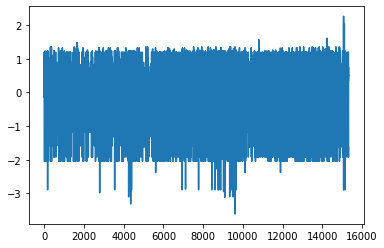

In [ ]:
df_pred.iloc[:,1].plot()

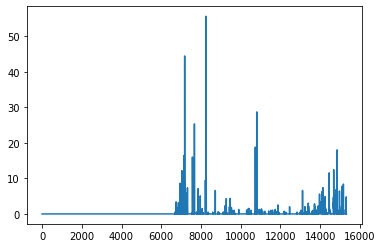

In [ ]:
df_original.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.313973
1    0.731994
2    0.216140
3    0.366688
dtype: float64

##### 3rd

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           512       
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 64, 16)            3600

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 5s 328us/sample - loss: 38463.5559 - val_loss: 1013.6724
Epoch 2/150
13788/13788 [==============================] - 3s 184us/sample - loss: 667.2836 - val_loss: 298.9218
Epoch 3/150
13788/13788 [==============================] - 3s 189us/sample - loss: 230.5855 - val_loss: 154.0008
Epoch 4/150
13788/13788 [==============================] - 3s 189us/sample - loss: 134.7031 - val_loss: 102.4419
Epoch 5/150
13788/13788 [==============================] - 3s 192us/sample - loss: 87.8915 - val_loss: 73.2523
Epoch 6/150
13788/13788 [==============================] - 3s 189us/sample - loss: 63.6619 - val_loss: 55.9267
Epoch 7/150
13788/13788 [==============================] - 3s 189us/sample - loss: 48.9652 - val_loss: 44.6228
Epoch 8/150
13788/13788 [==============================] - 3s 188us/sample - loss: 38.7342 - val_loss: 36.1371
Epoch 9/150
13788/13788 [===========================

In [ ]:
#2m34s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

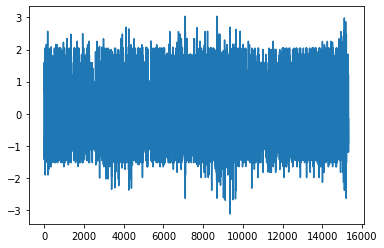

In [ ]:
df_pred.iloc[:,1].plot()

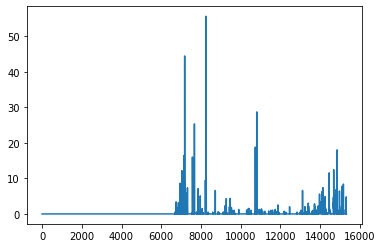

In [ ]:
df_original.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.057748
1    1.053378
2    0.065494
3    0.039895
dtype: float64

##### 5th

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 128 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 128)          4224      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 128)          4096      
_________________________________________________________________
encoded (Lambda)             (None, 128, 128)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 64, 16)            1435

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 3s 219us/sample - loss: 0.1422 - val_loss: 0.7708
Epoch 2/150
13788/13788 [==============================] - 3s 218us/sample - loss: 0.3633 - val_loss: 0.7064
Epoch 3/150
13788/13788 [==============================] - 3s 213us/sample - loss: 0.3578 - val_loss: 0.6571
Epoch 4/150
13788/13788 [==============================] - 3s 201us/sample - loss: 0.3573 - val_loss: 0.6145
Epoch 5/150
13788/13788 [==============================] - 3s 196us/sample - loss: 0.3567 - val_loss: 0.5709
Epoch 6/150
13788/13788 [==============================] - 3s 195us/sample - loss: 0.3565 - val_loss: 0.5407
Epoch 7/150
13788/13788 [==============================] - 3s 196us/sample - loss: 0.3597 - val_loss: 0.5067
Epoch 8/150
13788/13788 [==============================] - 3s 196us/sample - loss: 0.3857 - val_loss: 0.5782
Epoch 9/150
13788/13788 [==============================] - 3s 197us/sample - lo

In [ ]:
#1m27s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

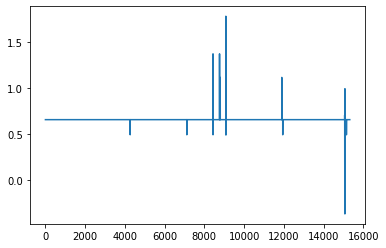

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.010805
1    3.146672
2    0.029043
3    0.053466
dtype: float64

##### 6th

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 64 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 128)          4224      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 128)          4096      
_________________________________________________________________
encoded (Lambda)             (None, 128, 128)          0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 64, 16)            143

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

In [ ]:
#2min45s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

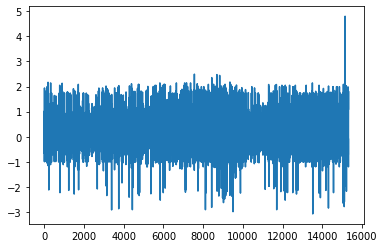

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.240052
1    0.109379
2    0.251415
3    0.114602
dtype: float64

##### 7th

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 32 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 32)           1056      
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 32)           1024      
_________________________________________________________________
encoded (Lambda)             (None, 128, 32)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 64, 16)            360

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 5s 375us/sample - loss: 34943.5364 - val_loss: 862.2060
Epoch 2/150
13788/13788 [==============================] - 3s 189us/sample - loss: 451.8809 - val_loss: 301.6417
Epoch 3/150
13788/13788 [==============================] - 3s 190us/sample - loss: 187.0707 - val_loss: 165.4759
Epoch 4/150
13788/13788 [==============================] - 3s 190us/sample - loss: 110.0284 - val_loss: 115.3801
Epoch 5/150
13788/13788 [==============================] - 3s 192us/sample - loss: 73.7665 - val_loss: 81.2648
Epoch 6/150
13788/13788 [==============================] - 3s 191us/sample - loss: 51.9346 - val_loss: 60.5010
Epoch 7/150
13788/13788 [==============================] - 3s 193us/sample - loss: 37.9940 - val_loss: 47.7040
Epoch 8/150
13788/13788 [==============================] - 3s 192us/sample - loss: 28.6945 - val_loss: 38.4234
Epoch 9/150
13788/13788 [============================

In [ ]:
#2min29s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

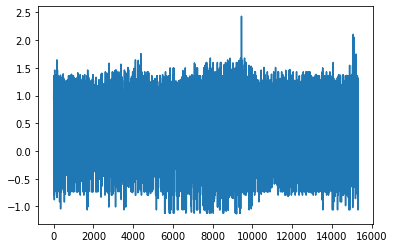

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.546322
1    2.918888
2    0.441983
3    0.376815
dtype: float64

##### 8th

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 32 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 128, 32)           928       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           512       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 64, 16)            1808

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 10s 241us/sample - loss: 15664.7282 - val_loss: 43.7144
Epoch 2/150
43153/43153 [==============================] - 8s 189us/sample - loss: 103.4545 - val_loss: 8.1529
Epoch 3/150
43153/43153 [==============================] - 8s 189us/sample - loss: 30.8622 - val_loss: 3.1704
Epoch 4/150
43153/43153 [==============================] - 8s 189us/sample - loss: 13.7178 - val_loss: 1.8390
Epoch 5/150
43153/43153 [==============================] - 8s 187us/sample - loss: 7.2959 - val_loss: 1.0918
Epoch 6/150
43153/43153 [==============================] - 8s 188us/sample - loss: 4.2304 - val_loss: 0.7888
Epoch 7/150
43153/43153 [==============================] - 8s 188us/sample - loss: 3.0070 - val_loss: 1.4655
Epoch 8/150
43153/43153 [==============================] - 8s 189us/sample - loss: 2.5446 - val_loss: 0.7498
Epoch 9/150
43153/43153 [==============================] - 8s 192us/s

In [ ]:
#4min1s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

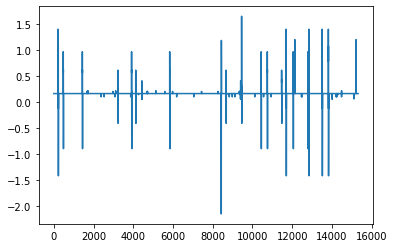

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.080580
1    0.011694
2    0.145490
3    0.156302
dtype: float64

##### 10th

In [ ]:
# Hyper Parameters.
epochs = 150 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           928       
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           256       
____________________________________________________________

In [ ]:
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43153 samples, validate on 4795 samples
Epoch 1/150
43153/43153 [==============================] - 22s 505us/sample - loss: 23131.7667 - val_loss: 81.6420
Epoch 2/150
43153/43153 [==============================] - 7s 167us/sample - loss: 107.7099 - val_loss: 16.0760
Epoch 3/150
43153/43153 [==============================] - 7s 166us/sample - loss: 33.8757 - val_loss: 6.8328
Epoch 4/150
43153/43153 [==============================] - 7s 166us/sample - loss: 17.3156 - val_loss: 3.9384
Epoch 5/150
43153/43153 [==============================] - 7s 167us/sample - loss: 10.5843 - val_loss: 2.6042
Epoch 6/150
43153/43153 [==============================] - 7s 166us/sample - loss: 7.1767 - val_loss: 1.6862
Epoch 7/150
43153/43153 [==============================] - 7s 168us/sample - loss: 5.4400 - val_loss: 1.2130
Epoch 8/150
43153/43153 [==============================] - 8s 181us/sample - loss:

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train_m)

In [ ]:
encoded_vae = dictionary_encoding(intermediate_output)

In [ ]:
embedded_size = sys.getsizeof(encoded_vae)
original_size = sys.getsizeof(X)
print("Compression: ", embedded_size/original_size)

Compression:  0.00042523180319027566


In [ ]:
#3m55s

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train_m)
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

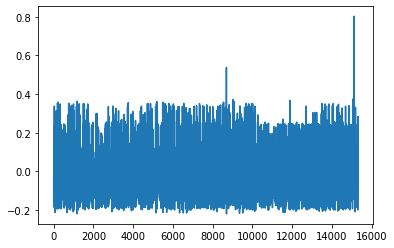

In [ ]:
df_pred.iloc[:,1].plot()

In [ ]:
difference_mean/original_mean

0    0.140477
1    1.019741
2    0.071016
3    0.064329
dtype: float64

In [ ]:
#CPU
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 13788 samples, validate on 1533 samples
Epoch 1/150
13788/13788 [==============================] - 13s 948us/sample - loss: 81399.1899 - val_loss: 3079.6923
Epoch 2/150
13788/13788 [==============================] - 12s 877us/sample - loss: 2298.1591 - val_loss: 913.7986
Epoch 3/150
13788/13788 [==============================] - 12s 877us/sample - loss: 678.5085 - val_loss: 429.3865
Epoch 4/150
13788/13788 [==============================] - 12s 877us/sample - loss: 294.9358 - val_loss: 234.5983
Epoch 5/150
13788/13788 [==============================] - 12s 883us/sample - loss: 153.3501 - val_loss: 149.7677
Epoch 6/150
13788/13788 [==============================] - 12s 889us/sample - loss: 94.2631 - val_loss: 107.2045
Epoch 7/150
13788/13788 [==============================] - 12s 891us/sample - loss: 67.6949 - val_loss: 84.0613
Epoch 8/150
13788/13788 [==============================] -

In [ ]:
#20min21

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train_m)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=4, kernel_size=7, padding = 'same')(x)


#
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
# Autoencoder.

vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
vqvae.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 4)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           928       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           256       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________

In [ ]:
import os
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

In [ ]:
# Model specific parameters

# TPU address
tpu_address = TF_MASTER

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: 10.107.77.242:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.107.77.242:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12655922209792169794)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9345516845503791905)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8599692543721159468)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6421530062137266078)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/dev

In [ ]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        vqvae,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TF_MASTER   + os.environ['COLAB_TPU_ADDR'])
        )
    )
tpu_model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=5e-2),
        loss= loss
    )

INFO:tensorflow:Querying Tensorflow master (grpc://10.107.77.242:847010.107.77.242:8470) for TPU system metadata.


In [ ]:
#TPU
history = vqvae.fit(x_train_m, x_train_m,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

### **Results**

In [ ]:
import matplotlib.pyplot as plt

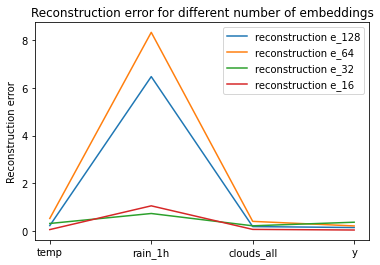

In [ ]:
#number of embeddings =  32 
e_128 = [0.225, 6.471, 0.183304, 0.143711]
e_64 = [0.525055, 8.327303, 0.402300, 0.210724]
e_32 = [0.313973, 0.731994, 0.216140, 0.366688]
e_16 = [0.057748, 1.053378, 0.065494, 0.039895]
ts = ['temp',	'rain_1h',	'clouds_all',	'y']
plt.plot( ts,e_128, label = 'reconstruction e_128')
plt.plot(ts,e_64, label = 'reconstruction e_64')
plt.plot(ts,e_32, label = 'reconstruction e_32')
plt.plot(ts,e_16, label = 'reconstruction e_16')
plt.title('Reconstruction error for different number of embeddings')
plt.legend()
plt.ylabel('Reconstruction error')
plt.show()

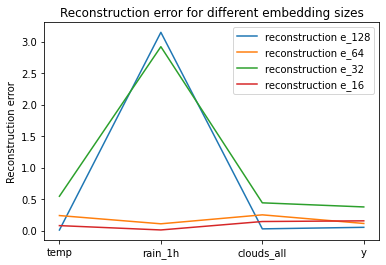

In [ ]:
# dimension of embeddings =  32 
e_128 = [0.010805, 3.146672, 0.029043, 0.053466]
e_64 = [0.240052, 0.109379, 0.251415, 0.114602]
e_32 = [0.546322, 2.918888, 0.441983, 0.376815]
e_16 = [0.080580, 0.011694, 0.145490, 0.156302]
ts = ['temp',	'rain_1h',	'clouds_all',	'y']
plt.plot( ts,e_128, label = 'reconstruction e_128')
plt.plot(ts,e_64, label = 'reconstruction e_64')
plt.plot(ts,e_32, label = 'reconstruction e_32')
plt.plot(ts,e_16, label = 'reconstruction e_16')
plt.title('Reconstruction error for different embedding sizes')
plt.ylabel('Reconstruction error')
plt.legend()
plt.show()

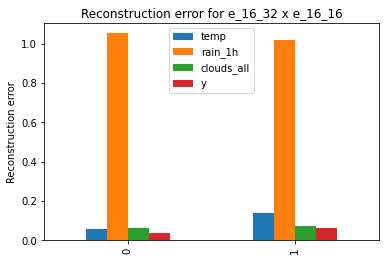

In [ ]:
e_16 = [0.057748, 1.053378, 0.065494, 0.039895]
e_min = [0.140477, 1.019741, 0.071016, 0.064329]
ts = ['temp',	'rain_1h',	'clouds_all',	'y']
df_c = pd.DataFrame(data = [e_16, e_min], columns= ts)
df_c.plot(y=df_c.columns, kind = 'bar')
labels = ['e_16_32', 'e_16_16']
plt.title('Reconstruction error for e_16_32 x e_16_16')
#plt.xticks(labels)
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
#PCA
original = []
for item in x_train_m:
  #print(item[0])
  original.append(item[0])

In [ ]:
from sklearn.decomposition import PCA
from sys import getsizeof
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(original)
X_recon = pca.inverse_transform(X_train_pca)
df_pca = pd.DataFrame(X_train_pca)

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(X_recon)
#print(df_pred.head())
original_mean = df_original.mean(axis = 0)
#print(original_mean)
difference = df_original - df_pred
#print(difference.head())
difference_mean = np.abs(difference.mean(axis = 0))
difference_mean/original_mean

0    2.230269e-14
1    1.190368e-14
2    2.537213e-17
3    8.584398e-20
dtype: float64

In [ ]:
#PCA
o_s = getsizeof(df_original)
c_s = getsizeof(df_pca)
print('ratio: ',c_s/o_s)

original size:  1534496
compressed size:  383744
ratio:  0.2500782015723729


In [ ]:
#VQ-VAE
embedded_size = sys.getsizeof(encoded_vae)
original_size = sys.getsizeof(X)
print("Ratio: ", embedded_size/original_size)

Ratio:  0.00042523180319027566


### New tests

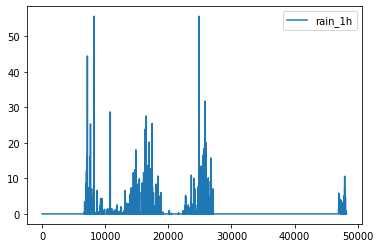

In [ ]:
df_training_value = pd.DataFrame(X_new)
df_training_value.plot()

In [ ]:
TIME_STEPS = 256

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)

train_dataset = create_sequences(df_training_value.values)
print("Training input shape: ", train_dataset.shape)
x_train = train_dataset

Training input shape:  (47948, 256, 1)


In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 16 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
# Encoder
input = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = Conv1D(filters=32, kernel_size=7,  strides=2,padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)

# VQVAELayer.
enc = Conv1D(embedding_dim, kernel_size=1, strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv1D(filters=16, kernel_size=7, strides=2, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Dropout(rate=0.2)(x)
x = Conv1D(filters=32, kernel_size=7,  strides=1, padding = 'same')(x)
x = UpSampling1D(size = 2)(x)
x = Conv1D(filters=1, kernel_size=7, padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 128, 32)           256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
pre_vqvae (Conv1D)           (None, 128, 16)           528       
_________________________________________________________________
vqvae (VQVAELayer)           (None, 128, 16)           256       
_________________________________________________________________
encoded (Lambda)             (None, 128, 16)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 64, 16)            1808

In [ ]:
history = vqvae.fit(x_train, x_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])

Train on 43153 samples, validate on 4795 samples
Epoch 1/50
43153/43153 [==============================] - 9s 217us/sample - loss: 34.6786 - val_loss: 29.0427
Epoch 2/50
43153/43153 [==============================] - 7s 170us/sample - loss: 34.3510 - val_loss: 16.9078
Epoch 3/50
43153/43153 [==============================] - 7s 172us/sample - loss: 21.4511 - val_loss: 9.8159
Epoch 4/50
43153/43153 [==============================] - 8s 174us/sample - loss: 18.7970 - val_loss: 4.8922
Epoch 5/50
43153/43153 [==============================] - 7s 174us/sample - loss: 18.4741 - val_loss: 2.4848
Epoch 6/50
43153/43153 [==============================] - 7s 174us/sample - loss: 13.8825 - val_loss: 1.3125
Epoch 7/50
43153/43153 [==============================] - 8s 174us/sample - loss: 8.8137 - val_loss: 0.8024
Epoch 8/50
43153/43153 [==============================] - 8s 174us/sample - loss: 6.0963 - val_loss: 0.6047
Epoch 9/50
43153/43153 [==============================] - 7s 173us/sample - los

In [ ]:
# Get train MAE loss.
x_train_pred_m = vqvae.predict(x_train)
original = []
for item in x_train:
  #print(item[0])
  original.append(item[0])
predicted = []
for item in x_train_pred_m:
  #print(item[0])
  predicted.append(item[0])

In [ ]:
df_original = pd.DataFrame(original)
df_pred = pd.DataFrame(predicted)
original_mean = df_original.mean(axis = 0)
difference = df_original - df_pred
difference_mean = np.abs(difference.mean(axis = 0))

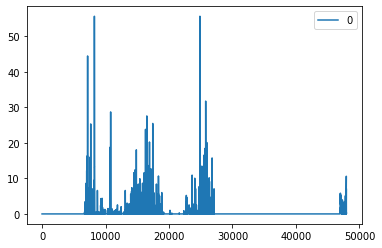

In [ ]:
df_original.plot()

In [ ]:
difference_mean/original_mean

0    0.393924
dtype: float64

In [ ]:
intermediate_layer_model = Model(inputs=vqvae.input,
                                 outputs=vqvae.get_layer("vqvae").output)
intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
encoded_vae_u = dictionary_encoding(intermediate_output)

In [ ]:
#VQ-VAE
embedded_size = sys.getsizeof(encoded_vae_u)
original_size = sys.getsizeof(df_training_value)
print("Ratio: ", embedded_size/original_size)

Ratio:  0.0017003981420039814


###2D Conv

In [ ]:
# Encoder
input = Input(shape=(x_train_m.shape[1], x_train_m.shape[2]))
x = Conv2D(filters=32, kernel_size=(7,7)  strides=(2,2),padding="same", activation="relu")(input)
x = Dropout(rate=0.2)(x)
encoder_output = Conv2D(filters=16, kernel_size=(7,7), padding="same", strides=(2,2), activation="relu")(x)

# VQVAELayer.
enc = Conv2D(embedding_dim, kernel_size=(1,1), strides=1, name="pre_vqvae")(x)
enc_inputs = enc
enc = VQVAELayer(embedding_dim, num_embeddings, commitment_cost, name="vqvae")(enc)
x = Lambda(lambda enc: enc_inputs + K.stop_gradient(enc - enc_inputs), name="encoded")(enc)
data_variance = np.var(x_train)
loss = vq_vae_loss_wrapper(data_variance, commitment_cost, enc, enc_inputs)

# Decoder.
x = Conv2D(filters=16, kernel_size=(7,7), strides=2, padding = 'same')(x)
x = UpSampling2D(size = (2,2))(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(filters=32, kernel_size=(7,7),  strides=1, padding = 'same')(x)
x = UpSampling2D(size = (2,2))(x)
x = Conv2D(filters=5, kernel_size=(7,7), padding = 'same')(x)

# Autoencoder.
vqvae = Model(input, x)
vqvae.compile(loss=loss, optimizer='adam')
vqvae.summary()

In [ ]:
# VQ layer.
class VQVAELayer(Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                  shape=(self.embedding_dim, self.num_embeddings),
                                  initializer=self.initializer,
                                  trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = K.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (K.sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * K.dot(flat_inputs, self.w)
                     + K.sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = K.argmax(-distances, axis=1)
        encodings = K.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = K.reshape(encoding_indices, K.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)

        # Metrics.
        #avg_probs = K.mean(encodings, axis=0)
        #perplexity = K.exp(- K.sum(avg_probs * K.log(avg_probs + epsilon)))

        return quantized

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = K.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(params=w, ids=encoding_indices)

In [ ]:
# Calculate vq-vae loss.
def vq_vae_loss_wrapper(data_variance, commitment_cost, quantized, x_inputs):
    def vq_vae_loss(x, x_hat):
        recon_loss = losses.mse(x, x_hat) / data_variance

        e_latent_loss = K.mean((K.stop_gradient(quantized) - x_inputs) ** 2)
        q_latent_loss = K.mean((quantized - K.stop_gradient(x_inputs)) ** 2)
        loss = q_latent_loss + commitment_cost * e_latent_loss

        return recon_loss + loss #* beta
    return vq_vae_loss

In [ ]:
# Hyper Parameters.
epochs = 50 # MAX
batch_size = 64
validation_split = 0.1

# VQ-VAE Hyper Parameters.
embedding_dim = 16 # Length of embedding vectors.
num_embeddings = 64 # Number of embedding vectors (high value = high bottleneck capacity).
commitment_cost = 0.25 # Controls the weighting of the loss terms.

# EarlyStoppingCallback.
esc = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                    patience=5, verbose=0, mode='auto',
                                    baseline=None, restore_best_weights=True)

In [ ]:
history = vqvae.fit(X, X,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[esc])